In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any

# Task 1: Define the GridWorld (The MDP)

In [2]:
class GridWorld:
    def __init__(self, living_penalty=-0.04, gamma=0.99):
        # Grid dimensions
        self.rows = 3
        self.cols = 4

        # Define special states
        self.wall = (1, 1)
        self.terminal_states = {
            (0, 3): 1.0,   # Goal (+1)
            (1, 3): -1.0   # Pit (-1)
        }

        # Actions: up, down, left, right
        self.actions = ['up', 'down', 'left', 'right']
        self.action_effects = {
            'up': (-1, 0),
            'down': (1, 0),
            'left': (0, -1),
            'right': (0, 1)
        }

        # MDP parameters
        self.living_penalty = living_penalty
        self.gamma = gamma  # Discount factor

        # Transition probabilities: [intended, left-slip, right-slip]
        self.transition_probs = [0.8, 0.1, 0.1]

        # Generate all valid states
        self.states = []
        for i in range(self.rows):
            for j in range(self.cols):
                if (i, j) != self.wall:
                    self.states.append((i, j))

    def get_reward(self, state: Tuple[int, int]) -> float:
        """Get reward for being in a state"""
        if state in self.terminal_states:
            return self.terminal_states[state]
        return self.living_penalty

    def is_terminal(self, state: Tuple[int, int]) -> bool:
        """Check if state is terminal"""
        return state in self.terminal_states

    def is_valid_state(self, state: Tuple[int, int]) -> bool:
        """Check if state is valid (within grid and not wall)"""
        i, j = state
        if (i, j) == self.wall:
            return False
        return 0 <= i < self.rows and 0 <= j < self.cols

    def get_next_state(self, state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Get next state given current state and action"""
        i, j = state
        di, dj = self.action_effects[action]
        next_state = (i + di, j + dj)

        # If next state is invalid, stay in current state
        if not self.is_valid_state(next_state):
            return state
        return next_state

    def get_transition_probabilities(self, state: Tuple[int, int], action: str) -> List[Tuple[float, Tuple[int, int]]]:
        """Get transition probabilities for state-action pair"""
        if self.is_terminal(state):
            return [(1.0, state)]  # Terminal states don't transition

        # Define slip directions relative to main action
        if action == 'up':
            slip_actions = ['left', 'right']
        elif action == 'down':
            slip_actions = ['right', 'left']
        elif action == 'left':
            slip_actions = ['down', 'up']
        elif action == 'right':
            slip_actions = ['up', 'down']

        # Calculate transitions
        transitions = []

        # Intended direction (80%)
        next_state_intended = self.get_next_state(state, action)
        transitions.append((self.transition_probs[0], next_state_intended))

        # Slip directions (10% each)
        for slip_action in slip_actions:
            next_state_slip = self.get_next_state(state, slip_action)
            transitions.append((self.transition_probs[1], next_state_slip))

        return transitions

    def get_possible_actions(self, state: Tuple[int, int]) -> List[str]:
        """Get all possible actions from a state"""
        if self.is_terminal(state):
            return []  # No actions in terminal states
        return self.actions

In [3]:
print("Creating 3x4 GridWorld environment...")
print("Special states:")
print("  Goal (0,3): +1 reward")
print("  Pit  (1,3): -1 reward")
print("  Wall (1,1): Blocked state")
print(f"Living penalty: -0.04")
print(f"Discount factor (gamma): 0.99")
print()

Creating 3x4 GridWorld environment...
Special states:
  Goal (0,3): +1 reward
  Pit  (1,3): -1 reward
  Wall (1,1): Blocked state
Living penalty: -0.04
Discount factor (gamma): 0.99



In [4]:
env = GridWorld()
test_state = (0, 0)
test_action = 'right'
transitions = env.get_transition_probabilities(test_state, test_action)
print(f"Transition test from state {test_state} with action '{test_action}':")
for prob, next_state in transitions:
    print(f"  P({prob:.1f}) -> {next_state}")
print()

Transition test from state (0, 0) with action 'right':
  P(0.8) -> (0, 1)
  P(0.1) -> (0, 0)
  P(0.1) -> (1, 0)



# Task 2: Value Iteration Algorithm (From Scratch)

In [5]:
def value_iteration(env: GridWorld, theta: float = 1e-4, max_iterations: int = 1000) -> Dict[Tuple[int, int], float]:
    """
    Value Iteration algorithm

    Parameters:
    - env: GridWorld environment
    - theta: convergence threshold
    - max_iterations: maximum number of iterations

    Returns:
    - V: converged value function
    """
    # Initialize value function
    V = {state: 0.0 for state in env.states}

    print("Running Value Iteration...")
    for iteration in range(max_iterations):
        delta = 0
        V_new = V.copy()

        for state in env.states:
            if env.is_terminal(state):
                V_new[state] = env.get_reward(state)
                continue

            # Calculate value for each action
            action_values = []
            for action in env.get_possible_actions(state):
                action_value = 0
                transitions = env.get_transition_probabilities(state, action)

                for prob, next_state in transitions:
                    reward = env.get_reward(next_state)
                    action_value += prob * (reward + env.gamma * V[next_state])

                action_values.append(action_value)

            # Update value with maximum action value
            if action_values:
                V_new[state] = max(action_values)

            # Track maximum change
            delta = max(delta, abs(V_new[state] - V[state]))

        V = V_new

        # Check convergence
        if delta < theta:
            print(f"Converged after {iteration + 1} iterations (delta = {delta:.6f})")
            break

        if iteration % 100 == 0:
            print(f"Iteration {iteration}: delta = {delta:.6f}")

    return V

# Run value iteration
V = value_iteration(env)
print()

Running Value Iteration...
Iteration 0: delta = 0.792000
Converged after 24 iterations (delta = 0.000054)



# Task 3: Policy Extraction (From Scratch)

In [6]:
def extract_policy(env: GridWorld, V: Dict[Tuple[int, int], float]) -> Dict[Tuple[int, int], str]:
    """
    Extract optimal policy from value function

    Parameters:
    - env: GridWorld environment
    - V: value function

    Returns:
    - policy: optimal policy mapping states to actions
    """
    policy = {}

    for state in env.states:
        if env.is_terminal(state):
            policy[state] = 'T'  # Terminal
            continue

        best_action = None
        best_value = -float('inf')

        for action in env.get_possible_actions(state):
            action_value = 0
            transitions = env.get_transition_probabilities(state, action)

            for prob, next_state in transitions:
                reward = env.get_reward(next_state)
                action_value += prob * (reward + env.gamma * V[next_state])

            if action_value > best_value:
                best_value = action_value
                best_action = action

        policy[state] = best_action

    return policy

# Extract optimal policy
policy = extract_policy(env, V)
print("Policy extraction completed")
print()

Policy extraction completed



# Task 4: Visualization and Analysis

Default Parameters (living_penalty = -0.04):
Value Function Table:
+-----------------------------------+
|   1.759 |   1.841 |   1.914 |   1.000 |
|   1.687 |   WALL   |   1.422 |  -1.000 |
|   1.607 |   1.538 |   1.463 |   1.025 |
+-----------------------------------+
Optimal Policy Table:
+-----------------------+
| → | → | → | G |
| ↑ | W | ↑ | P |
| ↑ | ← | ← | ← |
+-----------------------+


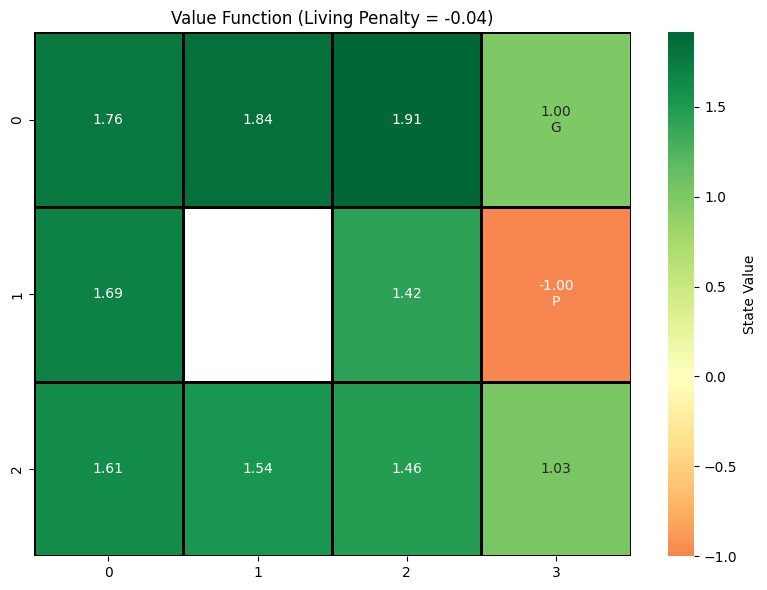

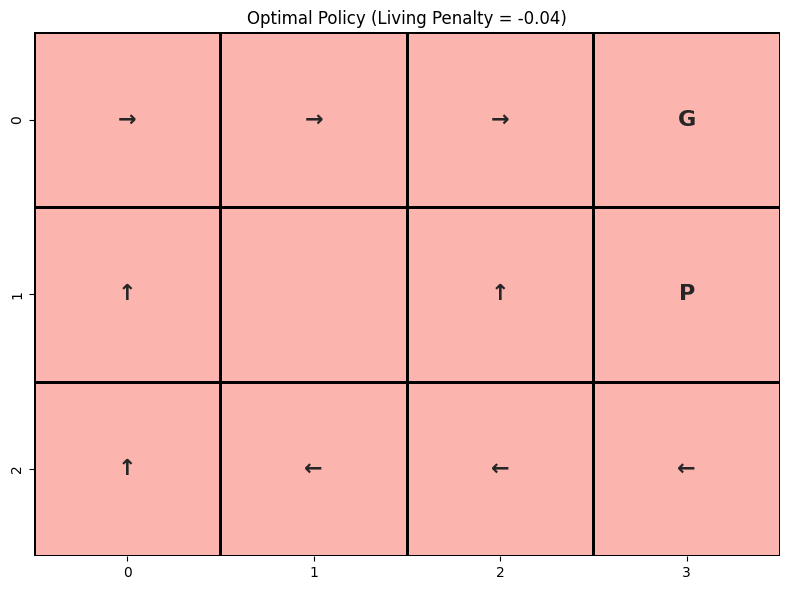

In [7]:
def visualize_value_function(env: GridWorld, V: Dict[Tuple[int, int], float], title: str = "Value Function"):
    """Visualize value function as heatmap"""
    # Create value matrix
    value_matrix = np.full((env.rows, env.cols), np.nan)

    for state, value in V.items():
        i, j = state
        value_matrix[i, j] = value

    # Create annotation matrix
    annotation_matrix = np.full((env.rows, env.cols), '', dtype=object)
    for state in env.states:
        i, j = state
        if state in env.terminal_states:
            annotation_matrix[i, j] = f"{value_matrix[i, j]:.2f}\n{'G' if env.terminal_states[state] > 0 else 'P'}"
        elif state == env.wall:
            annotation_matrix[i, j] = "WALL"
        else:
            annotation_matrix[i, j] = f"{value_matrix[i, j]:.2f}"

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    mask = np.isnan(value_matrix)
    sns.heatmap(value_matrix, annot=annotation_matrix, fmt='', cmap='RdYlGn',
                center=0, cbar_kws={'label': 'State Value'},
                mask=mask, linewidths=2, linecolor='black')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def visualize_policy(env: GridWorld, policy: Dict[Tuple[int, int], str], title: str = "Optimal Policy"):
    """Visualize policy as arrow grid"""
    # Create policy matrix
    policy_matrix = np.full((env.rows, env.cols), '', dtype=object)
    arrow_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', 'T': 'T'}

    for state, action in policy.items():
        i, j = state
        if state in env.terminal_states:
            policy_matrix[i, j] = 'G' if env.terminal_states[state] > 0 else 'P'
        elif state == env.wall:
            policy_matrix[i, j] = 'W'
        else:
            policy_matrix[i, j] = arrow_symbols.get(action, '?')

    # Create visualization matrix
    vis_matrix = np.zeros((env.rows, env.cols))

    plt.figure(figsize=(8, 6))
    mask = np.full((env.rows, env.cols), False)
    for state in env.states:
        i, j = state
        if state == env.wall:
            mask[i, j] = True

    sns.heatmap(vis_matrix, annot=policy_matrix, fmt='', cmap='Pastel1',
                cbar=False, mask=mask, linewidths=2, linecolor='black',
                annot_kws={'size': 16, 'weight': 'bold'})
    plt.title(title)
    plt.tight_layout()
    plt.show()

def print_value_table(env: GridWorld, V: Dict[Tuple[int, int], float]):
    """Print value function in grid format"""
    print("Value Function Table:")
    print("+" + "-"*35 + "+")
    for i in range(env.rows):
        row_str = "|"
        for j in range(env.cols):
            state = (i, j)
            if state == env.wall:
                row_str += "   WALL   |"
            elif state in V:
                row_str += f" {V[state]:7.3f} |"
            else:
                row_str += "          |"
        print(row_str)
    print("+" + "-"*35 + "+")

def print_policy_table(env: GridWorld, policy: Dict[Tuple[int, int], str]):
    """Print policy in grid format"""
    print("Optimal Policy Table:")
    print("+" + "-"*23 + "+")
    arrow_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', 'T': 'T'}

    for i in range(env.rows):
        row_str = "|"
        for j in range(env.cols):
            state = (i, j)
            if state == env.wall:
                row_str += " W |"
            elif state in policy:
                action = policy[state]
                symbol = arrow_symbols.get(action, '?')
                if state in env.terminal_states:
                    symbol = 'G' if env.terminal_states[state] > 0 else 'P'
                row_str += f" {symbol} |"
            else:
                row_str += "   |"
        print(row_str)
    print("+" + "-"*23 + "+")

# Visualize results for default parameters
print("Default Parameters (living_penalty = -0.04):")
print_value_table(env, V)
print_policy_table(env, policy)
visualize_value_function(env, V, "Value Function (Living Penalty = -0.04)")
visualize_policy(env, policy, "Optimal Policy (Living Penalty = -0.04)")

In [8]:
penalties = [0.0, -0.5]
penalty_descriptions = {
    0.0: "No living penalty",
    -0.5: "High living penalty (-0.5)"
}

for penalty in penalties:
    print(f"\nAnalysis with {penalty_descriptions[penalty]} (R(s) = {penalty}):")
    print("-" * 50)

    # Create new environment with different penalty
    env_modified = GridWorld(living_penalty=penalty)

    # Run value iteration
    V_modified = value_iteration(env_modified)

    # Extract policy
    policy_modified = extract_policy(env_modified, V_modified)

    # Visualize
    print_value_table(env_modified, V_modified)
    print_policy_table(env_modified, policy_modified)

    # Compare with default policy
    differences = []
    for state in env.states:
        if (state in policy and state in policy_modified and
            policy[state] != policy_modified[state] and not env.is_terminal(state)):
            differences.append((state, policy[state], policy_modified[state]))

    if differences:
        print(f"Policy changes: {len(differences)} states changed")
        for state, old_action, new_action in differences:
            print(f"  State {state}: {old_action} -> {new_action}")
    else:
        print("No policy changes detected")


Analysis with No living penalty (R(s) = 0.0):
--------------------------------------------------
Running Value Iteration...
Iteration 0: delta = 0.800000
Converged after 71 iterations (delta = 0.000098)
Value Function Table:
+-----------------------------------+
|   1.913 |   1.940 |   1.965 |   1.000 |
|   1.889 |   WALL   |   1.799 |  -1.000 |
|   1.863 |   1.839 |   1.815 |   1.647 |
+-----------------------------------+
Optimal Policy Table:
+-----------------------+
| → | → | → | G |
| ↑ | W | ← | P |
| ↑ | ← | ← | ↓ |
+-----------------------+
Policy changes: 2 states changed
  State (1, 2): up -> left
  State (2, 3): left -> down

Analysis with High living penalty (-0.5) (R(s) = -0.5):
--------------------------------------------------
Running Value Iteration...
Iteration 0: delta = 0.700000
Converged after 19 iterations (delta = 0.000056)
Value Function Table:
+-----------------------------------+
|   0.385 |   1.100 |   1.745 |   1.000 |
|  -0.243 |   WALL   |   0.814 |  -1.0